In [1]:
import torch
import pandas as pd
import astropy as ap
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
# from astropy.io import fits
import pdb
from scipy.ndimage.filters import maximum_filter1d
import glob
import fitsio as fits
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.distributions.normal import Normal
from tqdm import tqdm

In [2]:
import sys
sys.path.insert(0, '../')
sys.path.insert(1, '../latent_ode/')
import latent_ode.lib as ode
import latent_ode.lib.utils as utils
from latent_ode.lib.latent_ode import LatentODE
from latent_ode.lib.ode_rnn import ODE_RNN
from latent_ode.lib.encoder_decoder import Encoder_z0_ODE_RNN, Decoder
from latent_ode.lib.diffeq_solver import DiffeqSolver
from latent_ode.lib.ode_func import ODEFunc

### Loading

In [3]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [4]:

##################################################################
# Options
input_dim = 1
classif_per_tp = False
n_labels = 1
niters = 1
status_properties = ['loss']
latent_dim = 40

##################################################################
# Model
obsrv_std = torch.Tensor([0.1]).to(device)
z0_prior = Normal(torch.Tensor([0.0]).to(device), torch.Tensor([1.]).to(device))
gru_units = 40
n_ode_gru_dims = latent_dim
				
ode_func_net = utils.create_net(n_ode_gru_dims, n_ode_gru_dims, 
    n_layers = 2, n_units = 100, nonlinear = nn.Tanh)

rec_ode_func = ODEFunc(
    input_dim = input_dim, 
    latent_dim = n_ode_gru_dims,
    ode_func_net = ode_func_net,
    device = device).to(device)

z0_diffeq_solver = DiffeqSolver(input_dim, rec_ode_func, "dopri5", latent_dim, 
    odeint_rtol = 1e-3, odeint_atol = 1e-4, device = device)

model = ODE_RNN(input_dim=input_dim, latent_dim=latent_dim, 
            n_gru_units = 100, n_units = 100, device = device, 
			z0_diffeq_solver = z0_diffeq_solver,
			concat_mask = True, obsrv_std = obsrv_std,
			use_binary_classif = False,
			classif_per_tp = False,
			n_labels = 1,
			train_classif_w_reconstr = False
			).to(device)

disable_bias = True
if disable_bias:
    for module in model.modules():
        if hasattr(module, 'bias'):
            module.bias = None

##################################################################

In [5]:
model_file = 'ode_rnn_state_gaia.pth.tar'

In [6]:
state = torch.load(model_file, map_location=torch.device('cpu'))

In [7]:
model.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [8]:
model.eval()

ODE_RNN(
  (ode_gru): Encoder_z0_ODE_RNN(
    (GRU_update): GRU_unit(
      (update_gate): Sequential(
        (0): Linear(in_features=82, out_features=100, bias=False)
        (1): Tanh()
        (2): Linear(in_features=100, out_features=40, bias=False)
        (3): Sigmoid()
      )
      (reset_gate): Sequential(
        (0): Linear(in_features=82, out_features=100, bias=False)
        (1): Tanh()
        (2): Linear(in_features=100, out_features=40, bias=False)
        (3): Sigmoid()
      )
      (new_state_net): Sequential(
        (0): Linear(in_features=82, out_features=100, bias=False)
        (1): Tanh()
        (2): Linear(in_features=100, out_features=80, bias=False)
      )
    )
    (z0_diffeq_solver): DiffeqSolver(
      (ode_func): ODEFunc(
        (gradient_net): Sequential(
          (0): Linear(in_features=40, out_features=100, bias=False)
          (1): Tanh()
          (2): Linear(in_features=100, out_features=100, bias=False)
          (3): Tanh()
          (4): L

In [9]:
loader = torch.load('gaia_cv.pt')

## Inference

In [10]:
z_us = []
z_stds = []
truths = []
ts = []
recs = []
rec_stds = []
samples = []
for batch in tqdm(loader):
    observed = batch['observed_data'].to(device)
    true = batch['data_to_predict'].to(device)
    truths.extend([x for x in true])
    mask = batch['observed_mask'].to(device)
    mask_pred = batch['mask_predicted_data']#.to(device)
#     mask_pred = torch.ones(mask.shape)
    x = torch.cat((observed, mask), -1)
#     if not mask_pred:
#         mask_pred = torch.ones(true.shape)
    mask_pred = mask_pred.to(device)
    x2 = torch.cat((true, mask_pred), -1)
    t = batch['observed_tp'].to(device)
#     truth_time_steps = t[mask.nonzero()]
#     ts.append(t.detach().cpu())
    z_u, z_std = model.ode_gru.forward(x, t)
    rec = model.get_reconstruction(
        time_steps_to_predict=t, data=observed, truth_time_steps=t, mask=mask, n_traj_samples=20)[0].detach().cpu().squeeze()
#     rec_u = rec.mean(dim=0)
#     rec_std = rec.std(dim=0)
    recs.extend([x for x in rec])
#     rec_stds.extend([x for x in rec_std])
#     z_u = z_u.squeeze()
    z_u = z_u.detach().cpu()
    z_std = z_std.detach().cpu()
    z_us.append(z_u)
    z_stds.append(z_std)

100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


In [11]:
rec

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6123, 0.7034,
         0.7631, 0.7736, 0.7092, 0.6451, 0.6754, 0.6875, 0.6907, 0.7340, 0.7373,
         0.7389, 0.7386, 0.7362, 0.7352, 0.7329, 0.7322, 0.7311, 0.7309, 0.7313,
         0.7316, 0.7331, 0.7338, 0.7339, 0.7833, 0.7880, 0.7884, 0.7816, 0.7858,
         0.6842, 0.6943, 0.6974, 0.6840, 0.6921, 0.6918, 0.6649, 0.6704, 0.6699,
         0.6679, 0.6637, 0.6626, 0.6624, 0.6627],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6086, 0.6411,
         0.6218, 0.6309, 0.7245, 0.7301, 0.7306, 0.6479, 0.6501, 0.6516, 0.6517,
         0.6509, 0.6505, 0.6498, 0.6496, 0.6498, 0.6500, 0.6512, 0.6518, 0.6539,
         0.6549, 0.6577, 0.6589, 0.6591, 0.6620, 0.6634, 0.6636, 0.6669, 0.6683,
         0.6686, 0.6649, 0.6694, 0.7173, 0.6815, 0.6850, 0.6627, 0.6709, 0.6438,
         0.6492, 0.6463, 0.6446, 0.6440, 0.6434],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         

In [12]:
ix = 6

In [13]:
# y = samples[ix].detach().cpu().numpy().reshape(1,-1)
y = recs[ix].numpy().reshape(1,-1)
x = t.detach().cpu().numpy().reshape(1,-1)
y_true = truths[ix].detach().cpu().numpy().reshape(1,-1)

In [14]:
d_predict = np.concatenate([x, y], axis=0).T
d_true = np.concatenate([x, y_true], axis=0).T

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 50 and the array at index 1 has size 52

In [ ]:
df_predict = pd.DataFrame(d_predict, columns = ['t', 'value'])
df_predict['type'] = 'prediction'
df_truth = pd.DataFrame(d_true, columns = ['t', 'value'])
df_truth['type'] = 'truth'
df = pd.concat([df_predict, df_truth], 0)

In [ ]:
sns.scatterplot(x='t', y='value', data=df, hue='type')

In [ ]:
break

### Plot Multiple

In [49]:
loader = torch.load('gaia_cv.pt')

In [50]:
batch = next(iter(loader))

In [59]:
ix = 5

In [60]:
observed = batch['observed_data'][ix].unsqueeze(0).to(device)
true = batch['data_to_predict'][ix].unsqueeze(0).to(device)
mask = batch['observed_mask'][ix].unsqueeze(0).to(device)
t = batch['observed_tp'].to(device)

In [61]:
# a = t.min().item()
# b = t.max().item()
# step = (b-a)/1000
# t=torch.arange(a,b,step)

In [62]:
observed.shape

torch.Size([1, 52, 1])

In [63]:
rec = model.get_reconstruction(
    time_steps_to_predict=t, 
    data=observed, 
    truth_time_steps=t, 
    mask=mask, 
    n_traj_samples=20)[0].detach().cpu().squeeze()

In [64]:
rec = rec.detach().cpu().numpy()
truth = true.detach().squeeze().cpu().numpy()
obs = observed.squeeze().detach().cpu().numpy()
t_obs = t[obs != 0]
obs = obs[obs != 0]
t = t.detach().cpu().numpy()

In [65]:
plt.style.use('seaborn-darkgrid')
font = {'family': 'serif',
        'color':  'grey',
        'weight': 'light',
        'size': 12,
        }

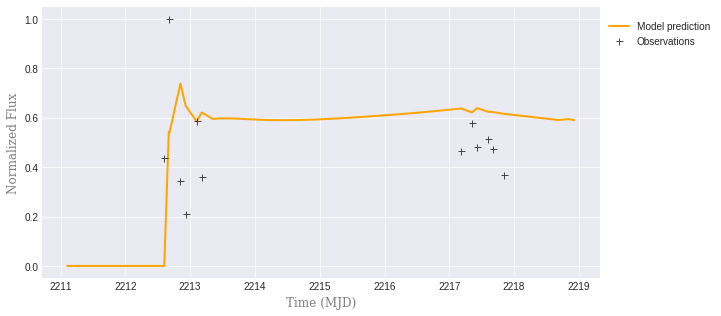

In [66]:
plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.plot(t, rec, marker='', color='orange', linewidth=2, alpha=1, label='Model prediction')
ax.plot(t_obs, obs, marker='+', color='black', linestyle='None', alpha=0.7, markersize=7, label='Observations')
plt.xlabel("Time (MJD)", fontdict=font)
plt.ylabel("Normalized Flux", fontdict=font)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.9),
          ncol=1, fancybox=True, shadow=True)
# ax.tick_params(
#     axis='both',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False,
#     labelleft=False,
#     right=False, 
#     left=False)